In [ ]:
# Mount Drive to Access Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0. IMPORTS & PATHS

In [ ]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(f"tf version: {tf.__version__}")

# Define paths
base_dir = '/content/drive/MyDrive/logo_detection/logo_detection_w281/'
image_dir = base_dir + 'data/images/'
os.chdir(base_dir)

tf version: 2.8.2


### 1. EDA

Image 1 is size: (768, 1024, 3)
Image 2 is size: (684, 1024, 3)
Notice different sizes ^^^


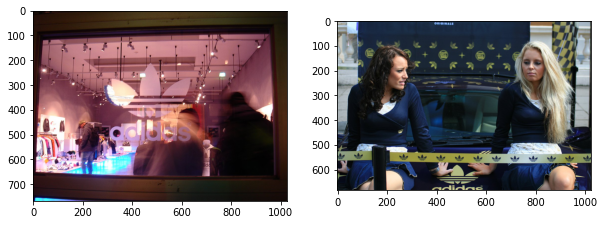

In [ ]:
# Load example image
adidas_dir = image_dir + 'adidas/'
adidas_img = plt.imread(adidas_dir + os.listdir(adidas_dir)[1])
adidas_img2 = plt.imread(adidas_dir + os.listdir(adidas_dir)[4])
print(f"Image 1 is size: {adidas_img.shape}")
print(f"Image 2 is size: {adidas_img2.shape}")
print("Notice different sizes ^^^")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(adidas_img)
ax[1].imshow(adidas_img2)
plt.show()

There are 32


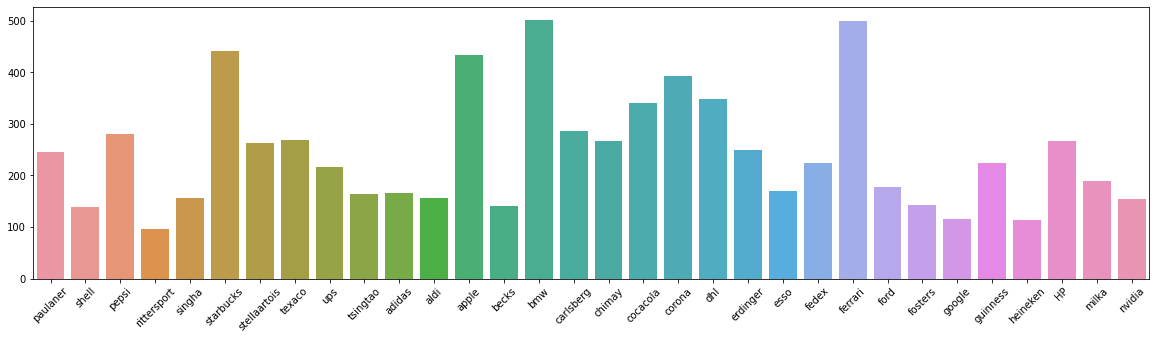

In [ ]:
# Investigate classes
logo_list = os.listdir(image_dir)
print(f"There are {len(logo_list)}")

# Plot number of examples per class
ex_counts = []
for logo in logo_list:
  count = len(os.listdir(image_dir + logo))
  ex_counts.append(count)

# make df
logo_counts = pd.DataFrame({'brand': logo_list, 'count': ex_counts})
logo_counts.sort_values('count', ascending=False, inplace=True)

# visualize
fig = plt.figure(figsize=(20,5))
sns.barplot(data=logo_counts, x=logo_list,
            y=ex_counts)
plt.xticks(rotation=45)
plt.show()

### 2. Create Train, Test Splits

In [ ]:
# Create file dataframe
labels = []
files = []
paths = []

for logo in logo_list:
  imgs = os.listdir(image_dir + logo)
  for img in imgs:
    files.append(img)
    labels.append(logo)
    paths.append(image_dir + logo + '/' + img)

img_df = pd.DataFrame({'label': labels, 'file': files, 'path': paths})
img_df.head()

,label,file,path
0,paulaner,005770.jpg,/content/drive/MyDrive/logo_detection/data/ima...
1,paulaner,005798.jpg,/content/drive/MyDrive/logo_detection/data/ima...
2,paulaner,005773.jpg,/content/drive/MyDrive/logo_detection/data/ima...
3,paulaner,005795.jpg,/content/drive/MyDrive/logo_detection/data/ima...
4,paulaner,005757.jpg,/content/drive/MyDrive/logo_detection/data/ima...


In [ ]:
# Randomly split df into train, test
test_size = .3
df_train, df_test, _, _ = train_test_split(img_df, img_df, test_size=test_size, random_state=42)

### 3. Modeling (Simple CNN Example)

In [ ]:
# Define data loading params
img_x = 64 #arbitrary for now
img_y = 64
batch_size = 32

# Batch image augmentation
train_gen = ImageDataGenerator(
    rescale = 1.0/255, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    rotation_range=20,
    horizontal_flip = True)
train_generator = train_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='label',
    target_size = (img_x, img_y),
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=True)

# Just rescale test, no augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='label',
    target_size = (img_x, img_y),
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=False)

Found 5481 validated image filenames belonging to 32 classes.
Found 2349 validated image filenames belonging to 32 classes.


In [ ]:
#### BUILD MODEL #### 
def build_simple_cnn(input_shape, batch_size, kernel_size, filters, pool_size, dropout, num_labels):
    inputs = Input(shape=(input_shape))
    
    # Conv + Pool #1
    conv1 = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(inputs)
    maxp1 = MaxPooling2D(pool_size)(conv1)
    drop1 = Dropout(dropout)(maxp1)
    
    # Conv + Pool #2
    conv2 = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(drop1)
    maxp2 = MaxPooling2D(pool_size)(conv2)
    drop2 = Dropout(dropout)(maxp2)
    
    # Flatten + Dropoout
    flat = Flatten()(drop2)
    drop4 = Dropout(dropout)(flat)
    
    # Fully Connected
    outputs = Dense(num_labels, activation = 'softmax')(drop4)
    
    # Build
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
# Model params
kernel_size = 7
pool_size=(2, 2)
filters = 8
dropout = 0.3
input_shape = (img_x, img_y, 3)
num_labels = len(logo_list)

# Training params
epochs = 1

model = build_simple_cnn(input_shape, batch_size, kernel_size, 
                         filters, pool_size, dropout, num_labels)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 8)         1184      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 29, 29, 8)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 29, 29, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 8)         3144      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 8)        0         
 2D)                                                       

In [ ]:
# Train model
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = test_generator,
                    validation_steps = test_generator.samples // batch_size)

  2/171 [..............................] - ETA: 1:09:52 - loss: 3.8302 - accuracy: 0.0156    

### 4. Evaluate Performance

In [ ]:
preds = model.predict(test_generator)

In [ ]:
# Get classification metrics

In [ ]:
# Investigate difficult classes